In [24]:
# Load dataset
import pandas as pd

data_path = "/content/dataset.csv"
df = pd.read_csv(data_path)

print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (1002, 17)


,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


In [25]:
# Check missing values and target column
print("Missing values per column:")
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])

# Check data types
print("\nData types:")
print(df.dtypes)

# Basic stats for target column 'price'
if "price" in df.columns:
    price = pd.to_numeric(df["price"], errors="coerce")
    print("\nTarget 'price' stats:")
    print("  Missing:", price.isna().sum())
    print("  Non-positive:", (price <= 0).sum())
    print("  Min:", price.min(), "| Median:", price.median(), "| Mean:", price.mean(), "| Max:", price.max())
else:
    print("\nColumn 'price' not found.")

Missing values per column:
cylinders         105
description        56
interior_color     38
mileage            34
price              23
fuel                7
doors               7
exterior_color      5
body                3
engine              2
transmission        2
trim                1
dtype: int64

Data types:
name               object
description        object
make               object
model              object
year                int64
price             float64
engine             object
cylinders         float64
fuel               object
mileage           float64
transmission       object
trim               object
body               object
doors             float64
exterior_color     object
interior_color     object
drivetrain         object
dtype: object

Target 'price' stats:
  Missing: 23
  Non-positive: 1
  Min: 0.0 | Median: 47165.0 | Mean: 50202.98569969356 | Max: 195895.0


In [26]:
# Drop rows with missing or zero price
df = df.copy()
initial_shape = df.shape

df = df[df["price"].notna() & (df["price"] > 0)]

print(f"Removed {initial_shape[0] - df.shape[0]} rows with missing or non-positive price.")
print("New shape:", df.shape)

Removed 24 rows with missing or non-positive price.
New shape: (978, 17)


In [27]:
# Impute or drop missing values based on column type and relevance

# Fill 'description' with empty string
df["description"] = df["description"].fillna("")

# Fill 'cylinders' with 0 for electric or unknown types
df["cylinders"] = df["cylinders"].fillna(0)

# Fill 'mileage' with median
df["mileage"] = df["mileage"].fillna(df["mileage"].median())

# Fill 'interior_color', 'exterior_color', 'fuel', 'doors', 'engine', 'transmission', 'trim', 'body' with 'Unknown'
fill_unknown = ["interior_color", "exterior_color", "fuel", "doors", "engine", "transmission", "trim", "body"]
for col in fill_unknown:
    df[col] = df[col].fillna("Unknown")

# Confirm cleanup
print("Remaining missing values:")
print(df.isna().sum().sort_values(ascending=False)[lambda x: x > 0])

Remaining missing values:
Series([], dtype: int64)


In [28]:
# Identify categorical and numeric features
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

# Drop target from feature lists
target = "price"
if target in num_cols:
    num_cols.remove(target)

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['name', 'description', 'make', 'model', 'engine', 'fuel', 'transmission', 'trim', 'body', 'doors', 'exterior_color', 'interior_color', 'drivetrain']
Numeric columns: ['year', 'cylinders', 'mileage']


In [29]:
# Select features and build preprocessing pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features to use (excluding name/description)
features = ['make', 'model', 'engine', 'fuel', 'transmission', 'trim', 'body',
            'doors', 'exterior_color', 'interior_color', 'drivetrain',
            'year', 'cylinders', 'mileage']

X = df[features]
y = df["price"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
cat_features = X.select_dtypes(include="object").columns.tolist()
num_features = X.select_dtypes(include="number").columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ("num", StandardScaler(), num_features)
])

print("Preprocessing pipeline ready.")

Preprocessing pipeline ready.


In [30]:
# Convert all categorical columns to string type
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print("All categorical columns converted to string.")

All categorical columns converted to string.


In [31]:
# Train a baseline Random Forest model and evaluate
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Full pipeline: preprocessing + model
model_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train
model_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model performance on test set:")
print("  MAE :", round(mae, 2))
print("  RMSE:", round(rmse, 2))
print("  R²   :", round(r2, 4))

Model performance on test set:
  MAE : 4245.2
  RMSE: 7615.15
  R²   : 0.8395


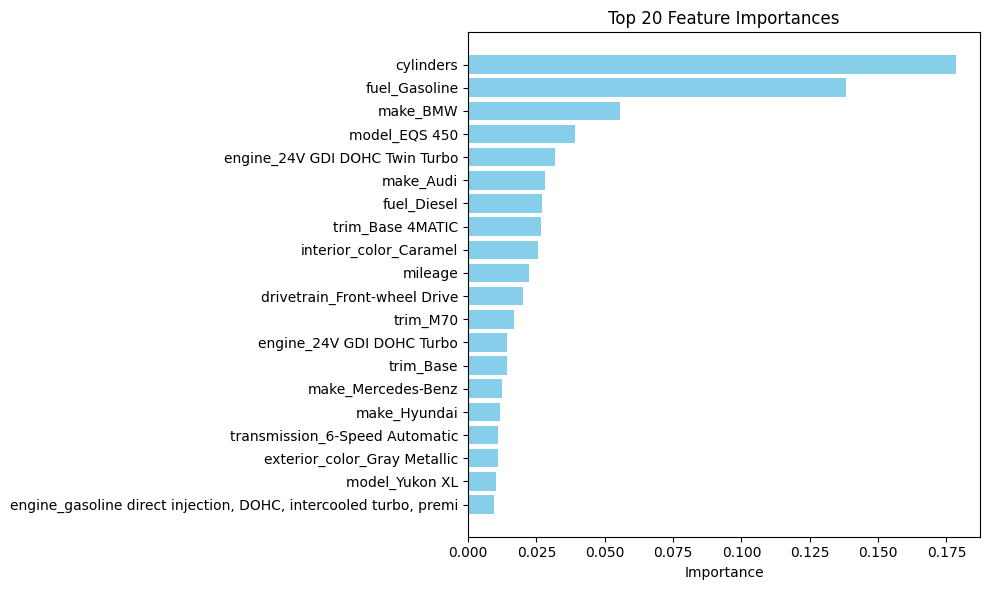

In [32]:
# Feature importances from trained model
import matplotlib.pyplot as plt

# Get feature names after preprocessing
ohe = model_pipeline.named_steps["preprocess"].named_transformers_["cat"]
num = model_pipeline.named_steps["preprocess"].named_transformers_["num"]

cat_feature_names = ohe.get_feature_names_out(cat_features)
num_feature_names = num_features
all_feature_names = np.concatenate([cat_feature_names, num_feature_names])

# Get importances
importances = model_pipeline.named_steps["regressor"].feature_importances_

# Create DataFrame
feat_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
plt.barh(feat_df["feature"].head(20)[::-1], feat_df["importance"].head(20)[::-1], color="skyblue")
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [33]:
# Compare multiple regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "HistGB": HistGradientBoostingRegressor(max_iter=100, random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("regressor", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append((name, round(mae, 2), round(rmse, 2), round(r2, 4)))

# Display results
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"]).sort_values(by="R²", ascending=False)
print("\n Model Comparison:")
display(results_df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 782, number of used features: 75
[LightGBM] [Info] Start training from score 50547.235294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



 Model Comparison:


,Model,MAE,RMSE,R²
3,XGBoost,4048.41,6970.99,0.8655
0,Random Forest,4245.20,7615.15,0.8395
2,Ridge Regression,4132.91,7675.90,0.8369
1,Linear Regression,4290.52,7807.49,0.8313
4,LightGBM,5622.36,8756.96,0.7878
5,HistGB,5720.69,8890.12,0.7813


In [34]:
# Hyperparameter tuning for XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define parameter grid
param_grid = {
    "regressor__max_depth": [3, 5, 7],
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__n_estimators": [100, 200],
    "regressor__subsample": [0.8, 1.0],
    "regressor__colsample_bytree": [0.8, 1.0],
    "regressor__reg_alpha": [0, 0.1],
    "regressor__reg_lambda": [1, 2]
}

# Wrap pipeline
xgb_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", XGBRegressor(random_state=42, verbosity=0))
])

# Grid search
grid = GridSearchCV(xgb_pipe, param_grid, cv=3, scoring="neg_mean_absolute_error", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Tuned XGBoost performance:")
print("  MAE :", round(mae, 2))
print("  RMSE:", round(rmse, 2))
print("  R²   :", round(r2, 4))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 7, 'regressor__n_estimators': 200, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1, 'regressor__subsample': 1.0}

 Tuned XGBoost performance:
  MAE : 3707.22
  RMSE: 6829.71
  R²   : 0.8709


In [35]:
# Save the final tuned model pipeline
import joblib

model_path = "/content/xgb_price_model.pkl"
joblib.dump(best_model, model_path)

print(f"Model saved to: {model_path}")

Model saved to: /content/xgb_price_model.pkl


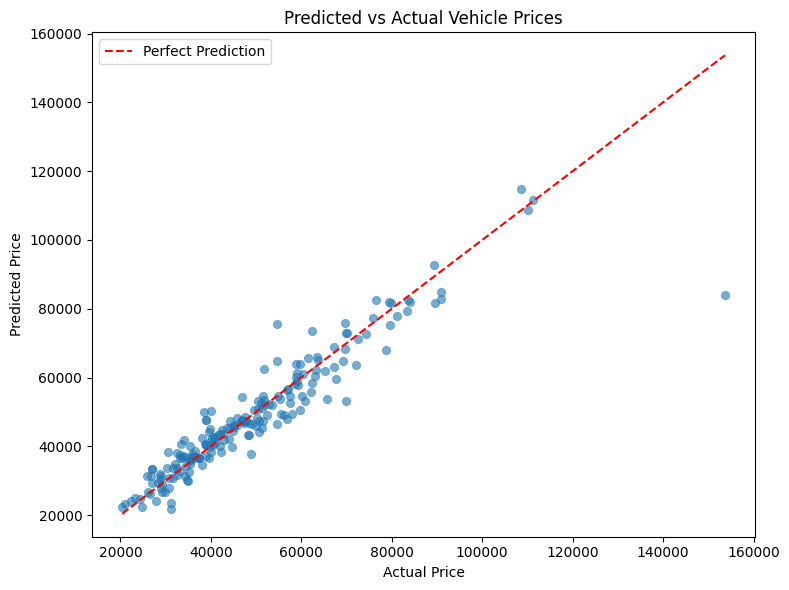

In [36]:
# Plot predicted vs actual prices
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Vehicle Prices")
plt.legend()
plt.tight_layout()
plt.show()

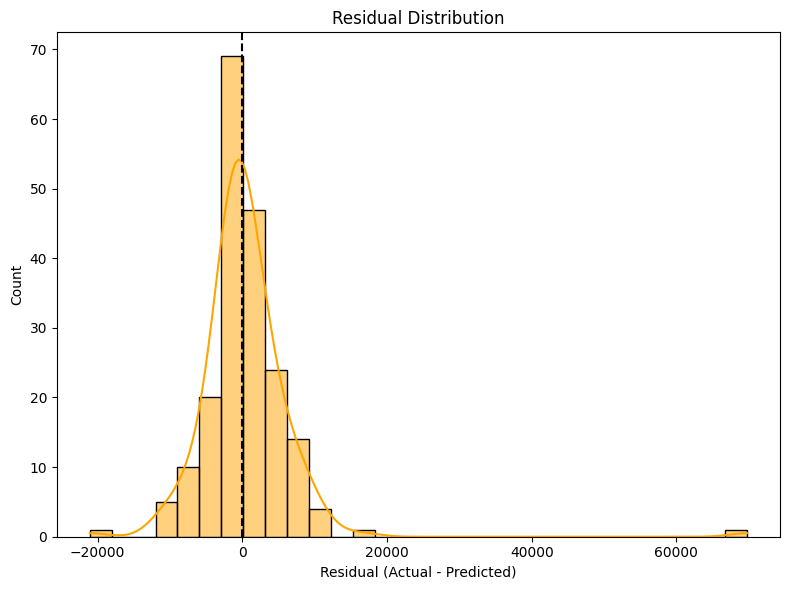

In [37]:
# Residuals plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color="orange")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

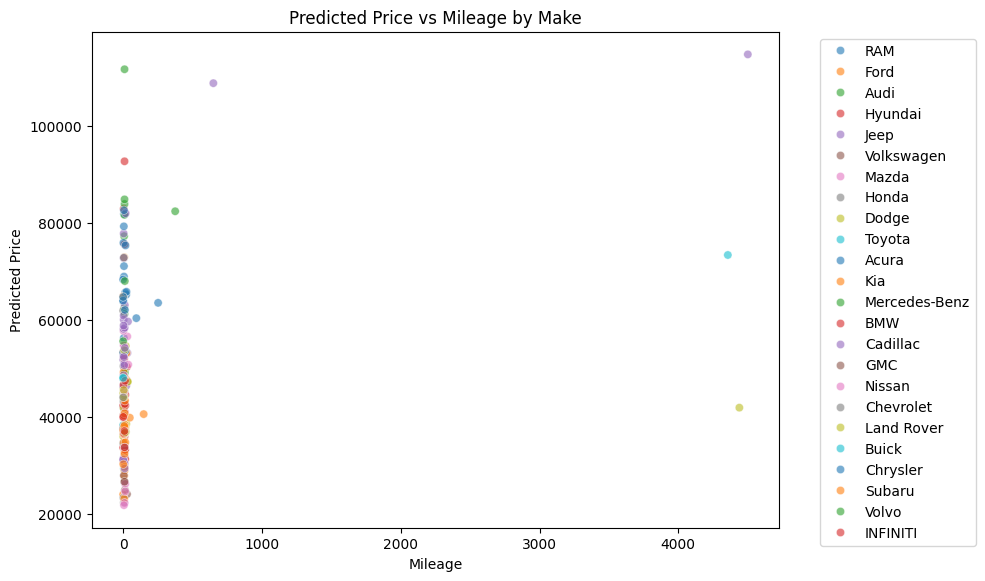

In [38]:
# Predicted price vs mileage, colored by make
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test["mileage"], y=y_pred, hue=X_test["make"], alpha=0.6, palette="tab10")
plt.xlabel("Mileage")
plt.ylabel("Predicted Price")
plt.title("Predicted Price vs Mileage by Make")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Visual Insights Summary

- **Predicted vs Actual Prices**: Most predictions align closely with actual prices, confirming model accuracy across the price spectrum.
- **Residual Distribution**: Errors are symmetrically distributed around zero, indicating no major bias or skew.
- **Feature Impact**: Engine specs, fuel type, and brand are key drivers of price, with `cylinders` and `make_BMW` leading the pack.
- **Mileage vs Predicted Price**: Price drops with mileage, but the rate varies by brand — luxury makes like RAM and Ford retain value better.